In [1]:
%matplotlib inline
import cortx_community as cc
import cortx_graphing as cg
import datetime
import matplotlib.pyplot as plt
import pandas as pd

# some variables used globally
ps=cc.PersistentStats()
goal_date=datetime.datetime(2021,12,31,0,0,0)
repo='GLOBAL'
df=cg.get_dataframe(ps=ps,repo=repo)
xlim=(None,goal_date)

# Overview

To best realize CORTX’s potential to reduce software costs and allow users to purchase more storage with their data center budgets, CORTX is 100% open source software. To maximize its utility, a vibrant engaged community is essential. This report describes and quantifies multiple goals for CORTX Community to allow us to identify opportunities for improvement so that we can best apply our resources.

CORTX Community goals are divided into four main categories: 

1. Awareness 
    * Ensuring that CORTX is known; positioning CORTX as useful, innovative, and interesting 
2. Community Development
    * Ensuring the community can attract and retain potential contributors 
3. Project Development
    * Ensuring the community can and does contribute to the development of CORTX 
4. Adoption 
    * Ensuring the project supports and encourages implementation

This report is accordingly split into 4 sections (one for each category). Within each category, we track dozens of metrics but in this report, we focus merely on just a few select metrics for each category which we feel present the most meaningful, yet concise, overview of CORTX Community.

## Awareness

Within Awareness, our topline metrics are as follows: 

1. Github Visits/Views (weekly average) 
2. Referrals from Seagate
3. Newsletter Subscriptions 

For two of these, we can make a graph using data scraped from github.  For newsletter subscriptions, we have to manually add the data (using another Jupyter notebook) but then we can make that graph as well.

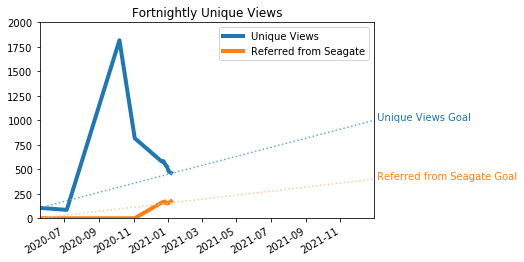

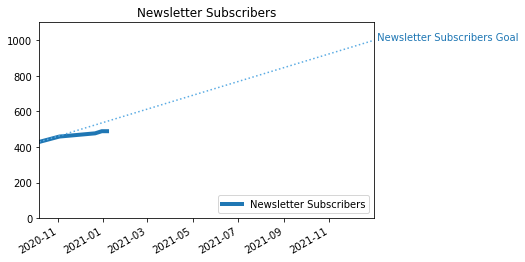

In [2]:
# make the graph for visits/views and referrals
title='Fortnightly Unique Views'
metric1='Unique Views'
metric2='Referred from Seagate'
df[metric1] = df['views_unique_14_days']
df[metric2] = df['seagate_referrer_uniques'] + df['seagate_blog_referrer_uniques']
goal1 = cg.Goal(metric1, goal_date,1000)
goal2 = cg.Goal(metric2, goal_date, 400)
plt = cg.goal_graph(df=df,title=title,xlim=xlim,goals=[goal1,goal2],columns=[metric1,metric2])
plt.legend(loc='upper right')
plt.show()

# make the graph for newsletter subscriptions
news_key='newsletter_subscribers'
metric3=news_key.replace('_',' ').title()
df[metric3] = df[news_key]
goal3 = cg.Goal(metric3, goal_date,1000)
plt = cg.goal_graph(df=df,title=metric3,xlim=xlim,goals=[goal3],columns=[metric3])
plt.show()

## Community Development

Within community development, our topline metrics are as follows:

1. Slack Total Members
2. Slack WAU average
3. Webinar Attendance
4. Github Engaged Members (Innersource + External)

Of these, only github is currently in our automatically scraped data but the rest can also be plotted by manually entering the data.

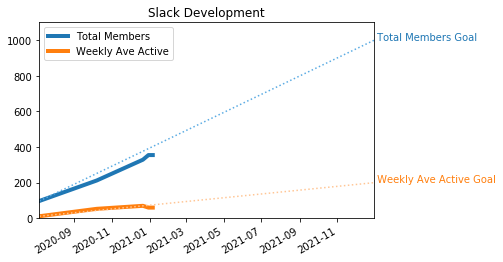

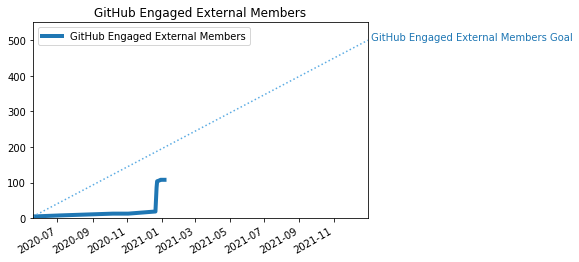

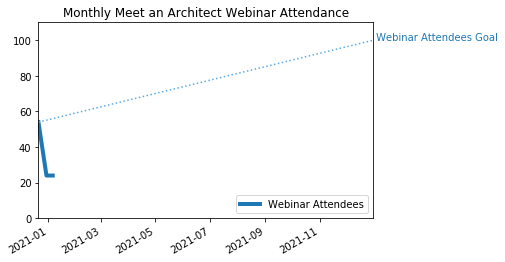

In [3]:
title='Slack Development'
slack_members_key='slack_total_members'
slack_wau_key='slack_weekly_ave_active'
def nice_slack_title(ugly):
    return ugly.replace('_', ' ').replace('slack ','').title()

members_str=nice_slack_title(slack_members_key)
wau_str=nice_slack_title(slack_wau_key)
df[members_str]=df[slack_members_key]
df[wau_str]=df[slack_wau_key]
members_goal=cg.Goal(members_str,goal_date,1000)
wau_goal=cg.Goal(wau_str,goal_date,200)
plt=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[members_goal,wau_goal],columns=[members_str,wau_str])
plt.legend(loc='upper left')
plt.show()

title='GitHub Engaged External Members'
df[title] = df['innersource_participants'] + df['external_participants']
plt=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[cg.Goal(title,goal_date,500)],columns=[title])
plt.legend(loc='upper left')
plt.show()

title='Monthly Meet an Architect Webinar Attendance'
ugly='webinar_attendees'
pretty=nice_slack_title(ugly)
df[pretty]=df[ugly]
plt=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[cg.Goal(pretty,goal_date,100)],columns=[pretty])
plt.show()

## Project Development

Within project development, our topline metrics are as follows:

1. External Submissions (issues + PRs)
2. External Merged PRs
3. Acceptance Rate of External PRs

Of these, all can be plotted from our automatically scraped data:

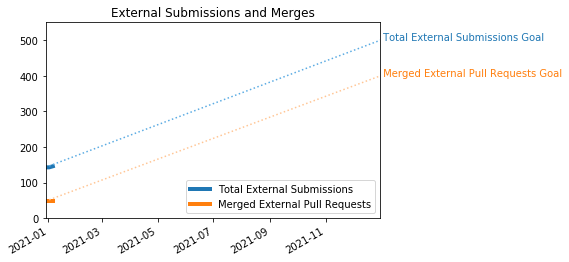

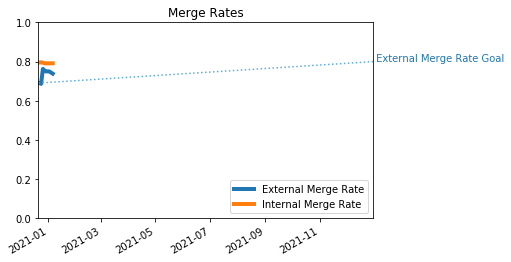

In [4]:
def remove_date(df,date):
    try:
        df=df.drop(pd.to_datetime(date),axis=0) # this first scrape was no good, double counted issues and pulls
    except KeyError:
        pass # was already dropped
    return df

metric1='Total External Submissions'
metric2='Merged External Pull Requests'
df[metric1] = df['pull_requests_external']+df['issues_external']
df[metric2] = df ['pull_requests_external_merged']
ts_goal=cg.Goal(metric1,goal_date,500)
mp_goal=cg.Goal(metric2,goal_date,400)
# initially we had misidentified some external people and it screwed up some data, so manually remove some here
save_df=df
df=remove_date(df,'2020-12-21')
df=remove_date(df,'2020-12-22')
df=remove_date(df,'2020-12-23')
df=remove_date(df,'2020-12-24')
df=remove_date(df,'2020-12-26')
plt=cg.goal_graph(df=df,title='External Submissions and Merges',xlim=xlim,columns=[metric1,metric2],goals=[ts_goal,mp_goal])
plt.show()

# restore df for the rest of the graphs
df=save_df
mr='Merge Rate'
mr_columns=[]
for k in ['external','internal']:
    mr_column=('%s merge rate' % k).title()
    df[mr_column] = df['pull_requests_%s_merged' % k] / df['pull_requests_%s' % k]
    mr_columns.append(mr_column)
mr_goal=cg.Goal('external merge rate'.title(),goal_date,0.8)
plt1=cg.goal_graph(df=df,title='Merge Rates',xlim=xlim,ylim=(0,1),columns=mr_columns,goals=[mr_goal])
plt1.show()

## Adoption

Within adoption, our topline metrics are as follows:

1. VM Downloads
2. External Orgs / Potential Partners
3. Total Integrations

Of these, two can be plotted from our automatically scraped data:

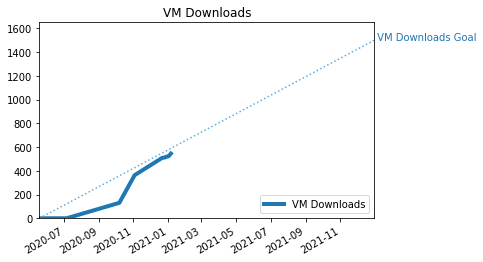

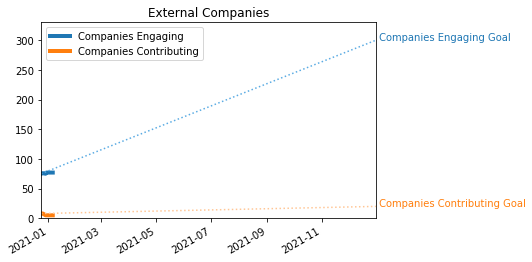

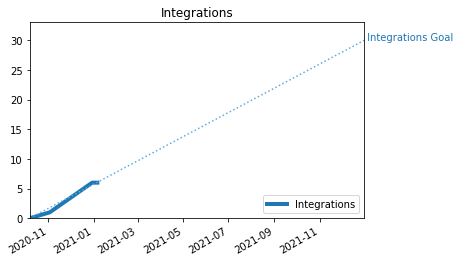

In [5]:
title='VM Downloads'
df[title] = df['downloads_vms']
plt=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[cg.Goal(title,goal_date,1500)],columns=[title])
plt.show()

title='External Companies'
e_title='Companies Engaging' 
c_title='Companies Contributing' 
df[e_title]=df['companies']
df[c_title]=df['companies_contributing']
try:
    df=df.drop(pd.to_datetime('2020-12-21'),axis=0)  # bit of an ugly value here which makes graph look bad
except KeyError:
    pass # might have already been dropped
columns=[e_title,c_title]
e_goal=cg.Goal(e_title,goal_date,300)
c_goal=cg.Goal(c_title,goal_date,20)
plt1=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[e_goal,c_goal],columns=[e_title,c_title])
plt1.legend(loc='upper left')
plt1.show()

key='integrations'
title=key.title()
df[title]=df[key]
goal=cg.Goal(title,goal_date,30)
plt2=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[goal],columns=[title])